In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input,Add,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D,AveragePooling2D,MaxPooling2D,GlobalMaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical   
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

import keras.backend as K

import tarfile
import matplotlib.pyplot as plt
import pickle

In [ ]:
def extract(path,file):
  tf=tarfile.open(path+rarfile) #one-time run to extract to dir
  tf.extractall()
  tf.close()

In [ ]:
def unpickle(file):
  with open(file,"rb") as fo:
    dict=pickle.load(fo,encoding='bytes')
  return dict

In [ ]:
def load_cifar(final, negatives=False):
  metadict=unpickle(final+"batches.meta")
  label_names=metadict[b'label_names']
  label_names=np.array(label_names)

  training_data=None
  training_labels=[]
  

  for i in range(1,6):
    training_data_dict=unpickle(final+"data_batch_{}".format(i))
    if i==1:
      training_data=training_data_dict[b'data']
    else:
      training_data=np.vstack((training_data,training_data_dict[b'data']))
    training_labels += training_data_dict[b'labels']

  training_data=training_data.reshape(len(training_data),3,32,32)


  if negatives:
    training_data=training_data.transpose(0,2,3,1).astype(np.float32)
  else:
    training_data = np.rollaxis(training_data, 1, 4)
  training_labels=np.array(training_labels)
  

  test_data=None
  test_labels=[]

  test_data_dict=unpickle(final+"test_batch")


  test_data=test_data_dict[b'data']
  test_labels = test_data_dict[b'labels']
  

  test_data=test_data.reshape(len(test_data),3,32,32)

  if negatives:
    test_data=test_data.transpose(0,2,3,1).astype(np.float32)
  else:
    test_data=np.rollaxis(test_data,1,4)

  test_labels=np.array(test_labels)
  
  return (training_data, training_labels, test_data, test_labels, label_names)

In [ ]:
path="/content/drive/My Drive/Colab Notebooks/"
rarfile="cifar-10-python.tar.gz"
final="/content/cifar-10-batches-py/"

extract(path,rarfile)    #one time use
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig ,labels=load_cifar(final)

print("Train data: ", X_train_orig.shape)
print("Train labels: ", Y_train_orig.shape)
print("Test data: ", X_test_orig.shape)
print("Test labels: ", Y_test_orig.shape)
print("Label names: ", labels.shape)

Train data:  (50000, 32, 32, 3)
Train labels:  (50000,)
Test data:  (10000, 32, 32, 3)
Test labels:  (10000,)
Label names:  (10,)


In [ ]:
'''#Normalization
X_train=X_train_orig.astype("float32")
X_valid=X_valid_orig.astype("float32")
X_test=X_test_orig.astype("float32")
mean=np.mean(X_train)
std=np.std(X_train)

#can divided by 255 (max value of color channel)
#X_train/=255
#X_valid/=255
#X_test/=255

#alternate
X_train=(X_train-mean)/(std+1e-7)
X_valid=(X_valid-mean)/(std+1e-7)
X_test=(X_test -mean)/(std+1e-7)'''
X_train=X_train_orig
X_test=X_test_orig

In [ ]:
Y_train=to_categorical(Y_train_orig,10)
Y_test=to_categorical(Y_test_orig,10)
#print(Y_train[10:30])
#print(Y_train_orig[10:30])

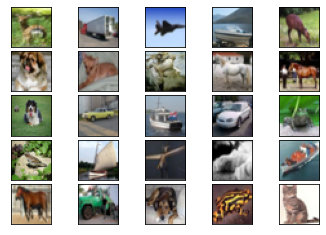

In [ ]:
num_plot = 5
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
         idx = np.random.randint(0, X_train.shape[0])
         ax[m, n].imshow(X_train_orig[idx])
         ax[m, n].get_xaxis().set_visible(False)
         ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()


In [ ]:
def VGG_model():
  # defining name basis
  conv_name_base = 'res_lay'
  bn_name_base = 'bn_lay'
  max_pool='mx_lay'    

  # Save the input value
  X_input=Input((32,32,3))
  X=X_input

  weight_decay=0.0005
  # First component of main path by default padding is taken valid
  X = Conv2D(64 , (3, 3), name = conv_name_base + '1a', padding='same', kernel_regularizer=l2(weight_decay),kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(name = bn_name_base + '1a')(X)
  X = Activation('relu')(X)

  X = Conv2D(64 , (3, 3), name = conv_name_base + '1b',padding='same',kernel_regularizer=l2(weight_decay))(X)
  X = BatchNormalization(name = bn_name_base + '1b')(X)
  X = Activation('relu')(X)

  x=MaxPooling2D(pool_size=(2,2), strides=2,name=max_pool+'1c')(X)
  # Second component of main path (≈3 lines)
  X = Conv2D(128, (3,3), padding = 'same', name = conv_name_base + '2a', kernel_regularizer=l2(weight_decay))(X)
  X=BatchNormalization(name=bn_name_base+'2a')(X)
  X = Activation('relu')(X)

  X = Conv2D(128, (3,3), padding = 'same', name = conv_name_base + '2b', kernel_regularizer=l2(weight_decay))(X)
  X=BatchNormalization(name=bn_name_base+'2b' )(X)
  X = Activation('relu')(X)

  x=MaxPooling2D(pool_size=(2,2), strides=2,name=max_pool+'2c')(X)

  # Third component of main path (≈2 lines)
  X = Conv2D(256, (3, 3),padding='same', name = conv_name_base + '3a', kernel_regularizer=l2(weight_decay))(X)
  X=BatchNormalization(name=bn_name_base+'3a' )(X)
  X = Activation('relu')(X)

  X = Conv2D(256, (3, 3),padding= 'same', name = conv_name_base + '3b', kernel_regularizer=l2(weight_decay))(X)
  X=BatchNormalization(name=bn_name_base+'3b' )(X)
  X = Activation('relu')(X)

  X = Conv2D(256, (3, 3),padding= 'same' , name = conv_name_base + '3c', kernel_regularizer=l2(weight_decay))(X)
  X=BatchNormalization(name=bn_name_base+'3c' )(X)
  X = Activation('relu')(X)

  x=MaxPooling2D(pool_size=(2,2), strides=2,name=max_pool+'3d')(X)

  # Fourth component of main path
  X = Conv2D(512, (3, 3),padding= 'same', name = conv_name_base + '4a', kernel_regularizer=l2(weight_decay))(X)
  X=BatchNormalization(name=bn_name_base+'4a' )(X)
  X = Activation('relu')(X)

  X = Conv2D(512, (3, 3),padding= 'same', name = conv_name_base + '4b', kernel_regularizer=l2(weight_decay))(X)
  X=BatchNormalization(name=bn_name_base+'4b' )(X)
  X = Activation('relu')(X)

  X = Conv2D(512, (3, 3),padding= 'same', name = conv_name_base + '4c', kernel_regularizer=l2(weight_decay))(X)
  X=BatchNormalization(name=bn_name_base+'4c' )(X)
  X = Activation('relu')(X)

  x=MaxPooling2D(pool_size=(2,2), strides=2,name=max_pool+'4d')(X)

  #fifth

  X = Conv2D(512, (3, 3),padding= 'same', name = conv_name_base + '5a', kernel_regularizer=l2(weight_decay))(X)
  X=BatchNormalization(name=bn_name_base+'5a' )(X)
  X = Activation('relu')(X)

  X = Conv2D(512, (3, 3),padding= 'same', name = conv_name_base + '5b', kernel_regularizer=l2(weight_decay))(X)
  X=BatchNormalization(name=bn_name_base+'5b' )(X)
  X = Activation('relu')(X)

  X = Conv2D(512, (3, 3),padding= 'same', name = conv_name_base + '5c', kernel_regularizer=l2(weight_decay))(X)
  X=BatchNormalization(name=bn_name_base+'5c' )(X)
  X = Activation('relu')(X)

  X=MaxPooling2D(pool_size=(2,2), strides=2,name=max_pool+'5d')(X)
  x=Dropout(0.5)(X)


  X= Flatten()(X)
  X= Dense(512, kernel_regularizer = l2(weight_decay),name='fc' + str(512))(X)
  X=BatchNormalization(name=bn_name_base+'6b' )(X)
  X = Activation('relu')(X)
  x=Dropout(0.5)(X)

  X= Dense(10, kernel_regularizer = l2(weight_decay), bias_regularizer=l2(weight_decay), name='fc' + str(10),activation='softmax')(X)

  model=Model(inputs=X_input,outputs=X,name='VGG_model')
  return model

In [ ]:
model=VGG_model()

In [ ]:
sgd=SGD(learning_rate=0.01, momentum=0.9, name='sgd')
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early=EarlyStopping(monitor='val_loss',min_delta=0.001,patience=30, mode='auto')
rlrop=ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience =10, mode='auto', min_delta=0.001)
checkpoint=ModelCheckpoint('tmp/checkpoint',monitor='val_accuracy',save_best_only=True, save_weights_only=False, mode='auto',)

In [ ]:
hist=model.fit(x=X_train, y=Y_train,  batch_size=128,epochs=200, validation_data=(X_test,Y_test),callbacks=[early, rlrop,checkpoint])

Epoch 1/200
391/391 [==============================] - ETA: 0s - loss: 4.0045 - accuracy: 0.4821WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: tmp/checkpoint/assets
391/391 [==============================] - 232s 593ms/step - loss: 4.0045 - accuracy: 0.4821 - val_loss: 3.8207 - val_accuracy: 0.5160
Epoch 2/200
391/391 [==============================] - 223s 570ms/step - loss: 3.4389 - accuracy: 0.6260 - val_loss: 4.3030 - val_accuracy: 0.4066
Epoch 3/200
391/391 [==============================] - 230s 589ms/step - loss: 3.0199 - accur

KeyboardInterrupt: ignored